In [2]:
import sys
!{sys.executable} -m pip install pymongo
!{sys.executable} -m pip install pyyaml
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
import os
print(os.getcwd())
# Get Mongo database
from yaml import load
from pymongo import MongoClient
secret = load(open("../../.getsecret.yaml"))

client = MongoClient(secret["MONGODB_URI"])
db = client[secret["DB_NAME"]]
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))
# counter for figures
counter = 0

/Users/drewgregory/JupyterNotebooks/habitlab-data-analysis


In [29]:
# Find number of users who didn't make it past onboarding.
num_users = 0
num_quit_users = 0
collections = db.list_collection_names()
for account in accounts:
    for user in account["android"]:
        num_users += 1
        if user+"_sessions" not in collections:
            num_quit_users += 1
print("Total Android users: " + str(num_users))
print("Android users who didn't make it past onboarding: " + str(num_quit_users))
print("% of quitters: " + str(num_quit_users/num_users))

Total Android users: 306
Android users who didn't make it past onboarding: 96
% of quitters: 0.3137254901960784


Average Number of sessions per day per user: 175.23242015920593


(array([166., 101.,  93.,  62.,  65.,  67.,  47.,  50.,  36.,  35.,  24.,
         24.,  26.,  17.,  14.,  15.,   9.,  12.,   7.,   9.,   2.,   6.,
          7.,   3.,   3.,   8.,   2.,   3.,   2.,   4.,   2.,   4.,   0.,
          0.,   0.,   1.,   0.,   0.,   3.,   1.,   1.,   1.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.]),
 array([1.0000e+00, 3.5700e+01, 7.0400e+01, 1.0510e+02, 1.3980e+02,
        1.7450e+02, 2.0920e+02, 2.4390e+02, 2.7860e+02, 3.1330e+02,
        3.4800e+02, 3.8270e+02, 4.1740e+02, 4.5210e+02, 4.8680e+02,
        5.2150e+02, 5.5620e+02, 5.9090e+02, 6.2560e+02, 6.6030e+02,
        6.9500e+02, 7.2970e+02, 7.6440e+02, 7.9910e+02, 8.3380e+02,
        8.6850e+02, 9.0320e+02, 9.3790e+02, 9.7260e+02, 1.0073e+03,
        1.0420e+03, 1.0767e+03, 1.1114e+03, 1.1461e+03, 1.1808e+03,
        1.2155e+03, 1.2502e+03, 1.2849e+03, 1.3196e+03, 1.3543e+03,
        1.3890e+03, 1.4237e+03, 1.4584e+03, 1.4931e+03, 1.5278e+03,
        1.5625e+03, 1.5972e+03, 1.6319e+03, 1.

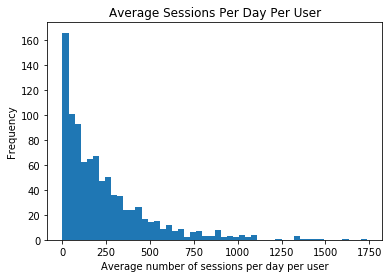

In [11]:
# Avg num of sessions:
import pandas
from statistics import mean
import matplotlib.pyplot as pyplot
total_sessions_per_day = 0
count_sessions_per_day = 0
avg_sessions_per_day_per_user = []
for account in accounts:
    for user in account["android"]:
        sessions_per_day = {}
        for session in db[user + "_sessions"].find():
            ts = pandas.Timestamp(ts_input=session["timestamp"], unit="ms")
            day = str(ts.year) + str(ts.month) + str(ts.day)
            if day not in sessions_per_day:
                sessions_per_day[day] = 0
            sessions_per_day[day] += 1
        arr = [sessions_per_day[day] for day in sessions_per_day]
        avg_sessions_per_day_per_user.extend(arr)
        if (len(arr) > 0):
            avg = mean(arr)
            total_sessions_per_day += avg
            count_sessions_per_day += 1
print("Average Number of sessions per day per user: " + str(total_sessions_per_day/count_sessions_per_day))
pyplot.figure(counter)
pyplot.title("Average Sessions Per Day Per User")
pyplot.ylabel("Frequency")
pyplot.xlabel("Average number of sessions per day per user")
pyplot.hist(avg_sessions_per_day_per_user, bins=50)

Skipped Days: 158


(array([265.,  17.,   5.,   8.,   6.,   1.,   1.,   0.,   1.,   2.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

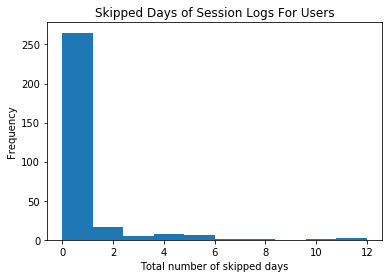

In [30]:
# See how many days we missed session logs when a user installed HabitLab
import pandas
import datetime
skipped_days = 0
num_users = 0
skipped_days_arr = []
for account in accounts:
    for user in account["android"]:
        prev_day = 0
        skipped_days_for_user = 0
        for session in db[user + "_sessions"].find():
            ts = pandas.Timestamp(ts_input=session["timestamp"], unit="ms")
            now_date = pandas.to_datetime(ts)
            day = (now_date-datetime.datetime.utcfromtimestamp(0)).days
            if prev_day == 0:
                prev_day = day
            if day - prev_day > 1:
                # The logging skipped a day!
                skipped_days_for_user += day - prev_day
            prev_day = day
        skipped_days_arr.append(skipped_days_for_user)
        skipped_days += skipped_days_for_user
print("Skipped Days: " + str(skipped_days))
counter += 1
pyplot.figure(counter)
pyplot.title("Skipped Days of Session Logs For Users")
pyplot.xlabel("Total number of skipped days")
pyplot.ylabel("Frequency")
pyplot.hist(skipped_days_arr)

<BarContainer object of 25 artists>

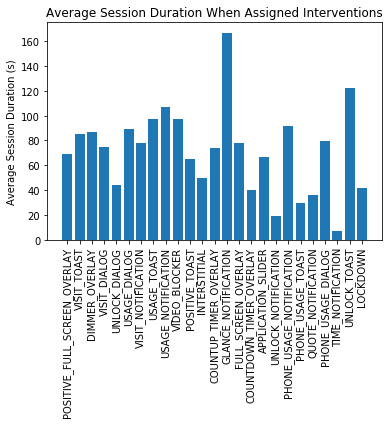

In [31]:
# Now let's analyze which interventions are most effective.
interventions = {}
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find({"enabled": True}):
            if "interventions" in session:
                for intervention in session["interventions"]:
                    intervention_name = intervention["intervention"]
                    if intervention_name not in interventions:
                        interventions[intervention_name] = {"total": 0, "count": 0}
                    interventions[intervention_name]["total"] += session["duration"]
                    interventions[intervention_name]["count"] += 1 
pyplot.figure(counter)
arr = 
counter += 1
pyplot.title('Average Session Duration When Assigned Interventions')
pyplot.ylabel('Average Session Duration (s)')
pyplot.xticks(rotation=90)
pyplot.bar([name for name in interventions], [interventions[name]["total"]/interventions[name]["count"] for name in interventions])
